## Настройка библиотек

### pandas

Для его настройки достаточно просто сделать импорт.

Также добавим numpy и matplotlib - пригодится для быстрых преобразований данных и визуализаций.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### pyspark

PySpark прежде всего требует установки самого Spark и платформы Java. Установим свободный JDK (Java development kit) версии 8. А Apache Spark скачаем версии 3.5.0 с Hadoop.

In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz
!tar xf spark-3.5.0-bin-hadoop3.tgz

После этого в окружение среды нужно указать пути JAVA_HOME и SPARK_HOME на скачанные программы. Поскольку мы напрямую загрузили Spark, то он находится в директории content. Чтобы их добавить воспользуемся модулем os, который предоставляет интерфейс для взаимодействия с файловой системой.

In [3]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "spark-3.5.0-bin-hadoop3"

Чтобы использовать PySpark как обычную Python-библиотеку, установим findspark, который сделает за нас остальную работу по инициализации.

In [4]:
!pip install findspark

Осталось инициализировать PySpark. Для этого вызывается метод findspark.init(), а дальше создаём точку входа кластера.

In [5]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

## Загрузка данных

Очень часто при анализе данных мы работаем с датасетами Kaggle — онлайн-площадки для соревнований по машинному обучению как в рамках конкурсов, так и для личных исследований. Обычно датасеты с Kaggle скачиваются напрямую на компьютер. Потом их загружают либо в Google Colab, либо в Google Drive. Причём если они загружаются с Drive, то придётся также их подгружать в Colab и вводить код доступа. Оба метода достаточно долгие, особенно если файлы большого размера. Поэтому загрузим файлы напрямую с Kaggle в Colab через Kaggle API.

Для этого, прежде всего необходимо создать аккаунт Kaggle (если у вас его еще нет). А затем в настройках аккаунта нужно создать API Token. Рисунок ниже показывает соответствующий раздел. После этого скачается файл kaggle.json, который содержит ваш личный код доступа.
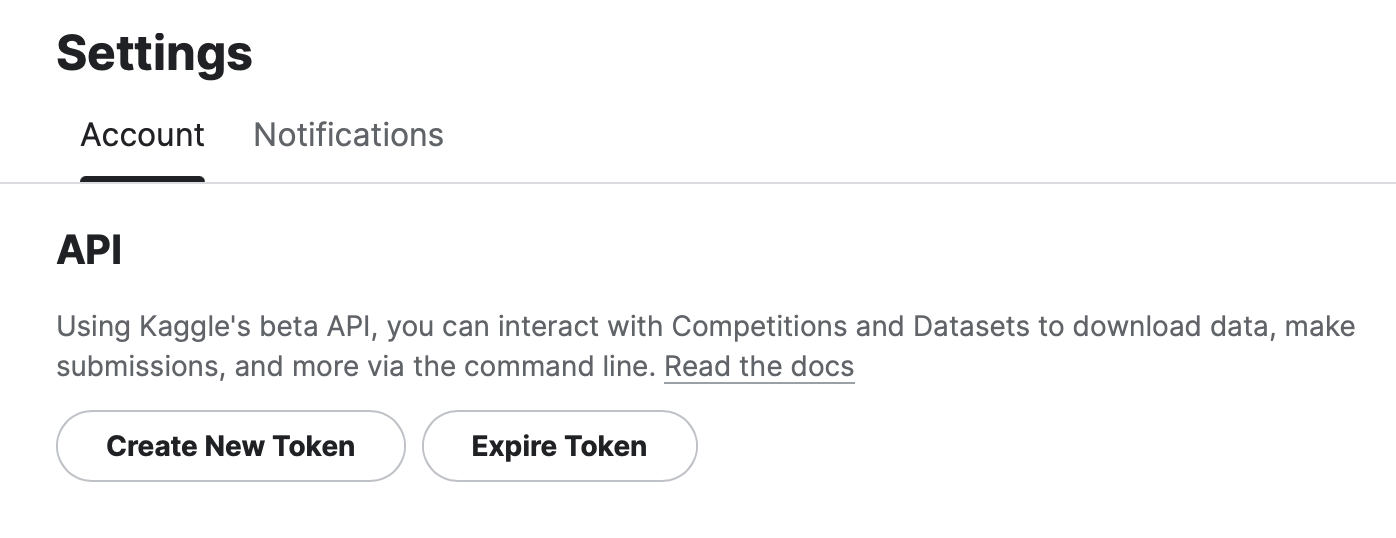

In [6]:
!mkdir /root/.kaggle
!touch /root/.kaggle/kaggle.json
!echo '{"username":"buskinaaliia","key":"bbe7241b10473134642fecfe46f87af4"}' > /root/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

В этой и следующей практиках будем работать с [датасетом](https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset), предназначенным для обучения алгоритма рекомендаций книг.

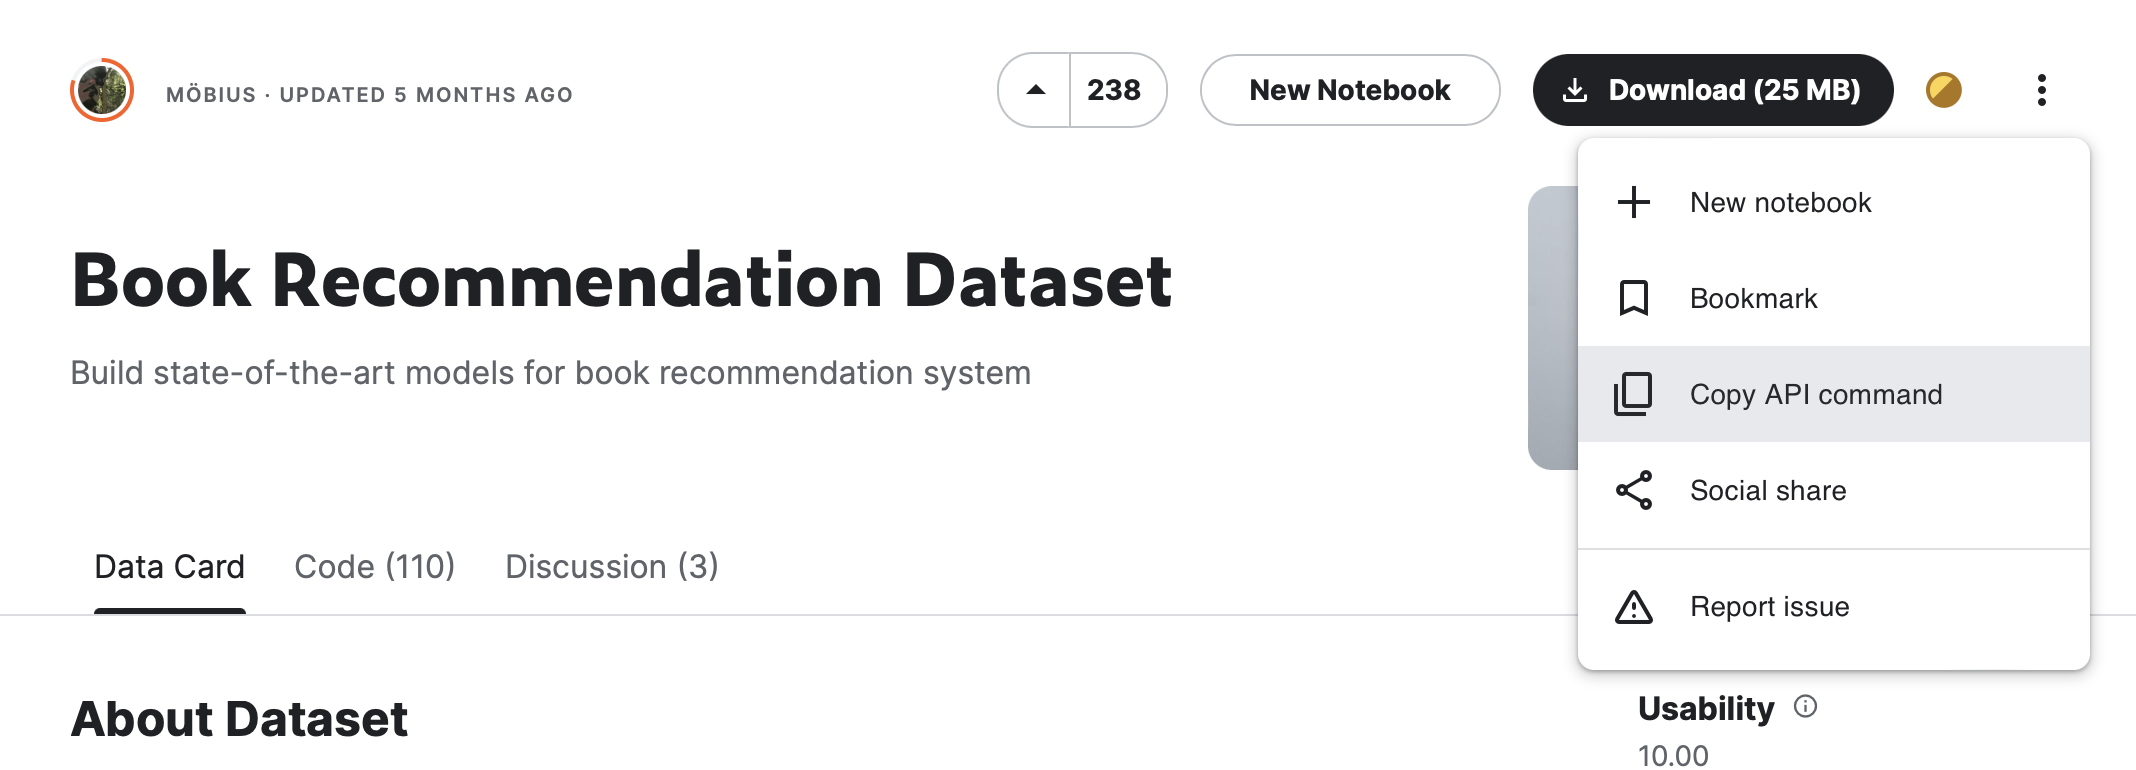

In [7]:
!kaggle datasets download -d arashnic/book-recommendation-dataset

 67% 16.0M/23.8M [00:00<00:00, 167MB/s]
100% 23.8M/23.8M [00:00<00:00, 151MB/s]


In [8]:
!unzip -q book-recommendation-dataset.zip

## Упражнения с данными в pandas

### Подготовка

Загрузим данные и посмотрим на них: выведите по 3 первые строки каждого датафрейма с помощью метода  [head()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.head.html).

In [9]:
books = pd.read_csv("Books.csv")
ratings = pd.read_csv("Ratings.csv")
users = pd.read_csv("Users.csv")

display(books.head(3))
display(ratings.head(3))
display(users.head(3))

<ipython-input-9-3b325d4d72fd>:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv("Books.csv")


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...


,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0


,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN


Посмотрим на размеры датафреймов.

In [10]:
books.shape, ratings.shape, users.shape

((271360, 8), (1149780, 3), (278858, 3))

Воспользуйтесь [функцией](https://pandas.pydata.org/docs/reference/api/pandas.merge.html#pandas.merge) или [методом](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html) merge, чтобы объединить три датафрейма в один.

In [11]:
books_ratings = pd.merge(
    books, ratings,
    left_on='ISBN',
    right_on='ISBN',
    how='inner'
)
books_merge = pd.merge(
    books_ratings, users,
    left_on='User-ID',
    right_on='User-ID',
    how='inner'
)
books_merge

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating,Location,Age
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,2,0,"stockton, california, usa",18.0
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,8,5,"timmins, ontario, canada",NaN
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,8,0,"timmins, ontario, canada",NaN
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,8,0,"timmins, ontario, canada",NaN
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,8,0,"timmins, ontario, canada",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1031131,087004124X,Anthem,Ayn Rand,1966,Caxton Press,http://images.amazon.com/images/P/087004124X.0...,http://images.amazon.com/images/P/087004124X.0...,http://images.amazon.com/images/P/087004124X.0...,259589,8,"venice, florida, usa",19.0
1031132,158243123X,A Student of Weather,Elizabeth Hay,2001,Counterpoint Press,http://images.amazon.com/images/P/158243123X.0...,http://images.amazon.com/images/P/158243123X.0...,http://images.amazon.com/images/P/158243123X.0...,259591,8,"tioga, pennsylvania, usa",39.0
1031133,8485900057,Rimas y leyendas (ClÃ¡sicos Fraile ; 3),Gustavo Adolfo BÃ©cquer,1981,Ediciones Fraile,http://images.amazon.com/images/P/8485900057.0...,http://images.amazon.com/images/P/8485900057.0...,http://images.amazon.com/images/P/8485900057.0...,259614,10,"madrid, madrid, spain",22.0
1031134,0838934854,Anglo-American Cataloguing Rules,Michael Gorman,1998,American Library Association,http://images.amazon.com/images/P/0838934854.0...,http://images.amazon.com/images/P/0838934854.0...,http://images.amazon.com/images/P/0838934854.0...,259679,6,"grand prairie, texas, usa",27.0


В столбце Location указано достаточно много данных: город, регион, страна. Давайте разделим этот столбец на три с помощью метода [str.split()](https://pandas.pydata.org/docs/reference/api/pandas.Series.str.split.html) с параметром expand=True. Если в процессе у вас образовались лишние столбцы, удалите их методом [drop()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html) с параметром inplace=True, чтобы не создавать новую таблицу. Это случилось потому, что со столбцом с локацией есть некоторые проблемы, но мы на них сейчас не будем обращать внимание.

In [12]:
locations = books_merge['Location'].str.split(',', expand=True)
books_merge['city'] = locations[0]
books_merge['region'] = locations[1]
books_merge['country'] = locations[2]
books_merge.drop(columns=['Location'], inplace=True)
books_merge

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating,Age,city,region,country
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,2,0,18.0,stockton,california,usa
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,8,5,NaN,timmins,ontario,canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,8,0,NaN,timmins,ontario,canada
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,8,0,NaN,timmins,ontario,canada
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,8,0,NaN,timmins,ontario,canada
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1031131,087004124X,Anthem,Ayn Rand,1966,Caxton Press,http://images.amazon.com/images/P/087004124X.0...,http://images.amazon.com/images/P/087004124X.0...,http://images.amazon.com/images/P/087004124X.0...,259589,8,19.0,venice,florida,usa
1031132,158243123X,A Student of Weather,Elizabeth Hay,2001,Counterpoint Press,http://images.amazon.com/images/P/158243123X.0...,http://images.amazon.com/images/P/158243123X.0...,http://images.amazon.com/images/P/158243123X.0...,259591,8,39.0,tioga,pennsylvania,usa
1031133,8485900057,Rimas y leyendas (ClÃ¡sicos Fraile ; 3),Gustavo Adolfo BÃ©cquer,1981,Ediciones Fraile,http://images.amazon.com/images/P/8485900057.0...,http://images.amazon.com/images/P/8485900057.0...,http://images.amazon.com/images/P/8485900057.0...,259614,10,22.0,madrid,madrid,spain
1031134,0838934854,Anglo-American Cataloguing Rules,Michael Gorman,1998,American Library Association,http://images.amazon.com/images/P/0838934854.0...,http://images.amazon.com/images/P/0838934854.0...,http://images.amazon.com/images/P/0838934854.0...,259679,6,27.0,grand prairie,texas,usa


Узнаем немного больше о книгах и пользователях.
1. Построим [гистограмму](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.hist.html) распределения возрастов пользователей. Видно, что там есть отсутствующие значения. Будем их пока игнорировать.

In [13]:
books_merge.Age.describe()

count    753301.000000
mean         37.397648
std          14.098254
min           0.000000
25%          28.000000
50%          35.000000
75%          45.000000
max         244.000000
Name: Age, dtype: float64

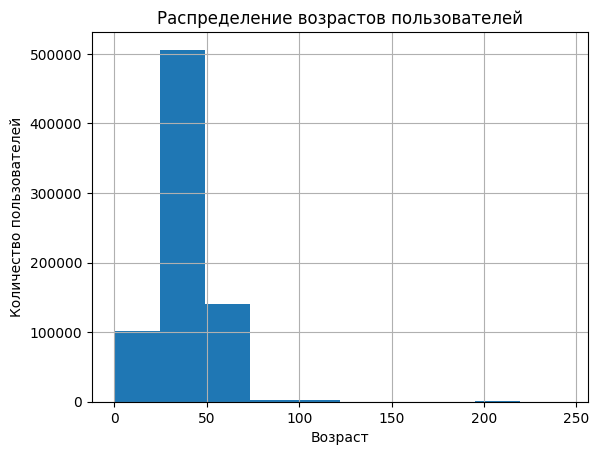

In [14]:
hist = books_merge['Age'].hist()

plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')
plt.title('Распределение возрастов пользователей')

plt.show()

Было бы неплохо не смотреть на то, что читают младенцы и мумии: посмотрим на возраст больше 0 и меньше 100. Для того, чтобы отсеять лишние строки, можно воспользоваться методом [query()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.query.html).

В конце строки, отвечающей за вывод визуализации для вывода изображения без лишних указателей, можно поставить `;` или в следующей строке написать plt.show().

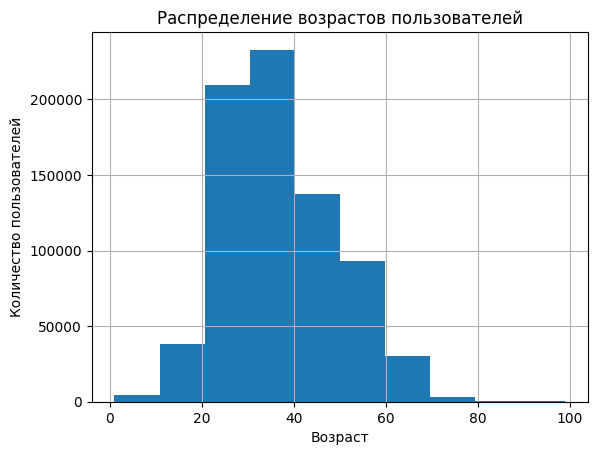

In [15]:
filtered_age = books_merge.query('0 < Age < 100')

hist_0_100 = filtered_age['Age'].hist()

plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')
plt.title('Распределение возрастов пользователей')

plt.show()

Какой можно сделать вывод о возрасте пользователей?

In [18]:
filtered_age.Age.describe()

count    749714.000000
mean         37.011026
std          12.159032
min           1.000000
25%          28.000000
50%          35.000000
75%          45.000000
max          99.000000
Name: Age, dtype: float64

Для пользователей с возрастом больше 100 лет поставим значение возраста np.nan. Можно сделать это с помощью метода [apply()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html), например.

In [19]:
books_merge['Age'] = books_merge['Age'].apply(lambda x: np.nan if x > 100 else x)
books_merge.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating,Age,city,region,country
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,2,0,18.0,stockton,california,usa
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,8,5,NaN,timmins,ontario,canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,8,0,NaN,timmins,ontario,canada
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,8,0,NaN,timmins,ontario,canada
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,8,0,NaN,timmins,ontario,canada


2. Выясним, книги каких эпох представлены в датасете. Для этого построим еще диаграмму, теперь - с распределением кол-ва книг по годам.


Вероятно, у вас возникла ошибка о невозможности сравнения строк и целых чисел. Посмотрите, нет ли чего несанкционированного в столбце с датой, например, выведя уникальные значения с помощью метода [unqiue()](https://pandas.pydata.org/docs/reference/api/pandas.Series.unique.html).

In [20]:
books_merge['Year-Of-Publication'].unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1992, 1989, 1976, 1985, 1980, 1995, 1997, 1983, 1987, 1990,
       1982, 0, 1965, 1986, 1960, 1974, 1978, 1984, 1973, 1959, 1942,
       1979, 1972, 1981, 1957, 1971, 1963, 1958, 1966, 1930, 1969, 1953,
       1970, 1947, 1977, 1954, 1920, 1955, 1975, 1964, 1967, 2030, 2005,
       1951, 1927, 1961, 1968, 1962, 1948, 1925, 1923, '2002', '1994',
       '1970', '1990', '1998', '1991', '1989', '0', '2001', '1986',
       '1999', '2000', '1996', '1981', '1985', '1987', '1995', '2003',
       '1988', '1976', '1979', '1993', '1984', '1997', '1975', '1983',
       '1992', '1980', '1982', '2004', '1974', '1977', '1971', '1978',
       '1972', '1958', '1969', '1966', '1967', '1973', '1968', 1938, 1956,
       '1964', 1901, 1926, 1940, '1941', '1959', '1942', '1963', '1962',
       '1922', '1957', '1897', '1960', '1949', '1956', '1939', '1955',
       '1961', '1952', '1933', '1954', '1965', '1944', 1952, 2011, 

In [21]:
books_merge_copy = books_merge.copy()
books_merge_copy["year"] = books_merge_copy["Year-Of-Publication"].apply(lambda x: x if str(x).isdigit() and int(x) > 0 and int(x) <= 2023 else np.nan)
books_merge_copy = books_merge_copy.dropna(subset=["year"])

<ipython-input-22-e205fb44a142>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  books_merge_copy['year'] = books_merge_copy['year'].astype(int)


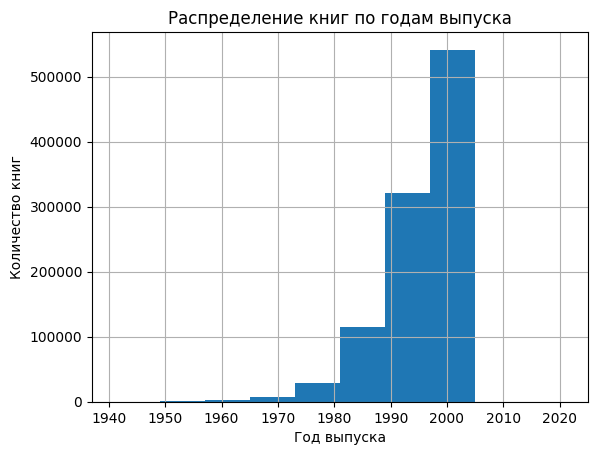

In [22]:
books_merge_copy['year'] = books_merge_copy['year'].astype(int)

hist_years = books_merge_copy.query("year>1940")['year'].hist()

plt.xlabel('Год выпуска')
plt.ylabel('Количество книг')
plt.title('Распределение книг по годам выпуска')

plt.show()

Часть чисел имеет вид строки - преобразовать не проблема. Но есть и две настоящих строки, на вид - названия издательств. Давайте посмотрим на строки с такими значениями.

In [23]:
books_merge_copy_2 = books_merge.copy()
books_merge_copy_2 = books_merge_copy_2[(books_merge_copy_2['Year-Of-Publication'] == 'DK Publishing Inc') | (books_merge_copy_2['Year-Of-Publication'] == 'Gallimard')]
books_merge_copy_2

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating,Age,city,region,country
287500,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-M...",2003,Gallimard,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,NaN,137190,0,31.0,rennes,bretagne,france
352361,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,NaN,227771,7,19.0,savion,n/a,israel
467962,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,NaN,130571,0,NaN,summerville,south carolina,usa
469216,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,NaN,169663,0,NaN,towson,maryland,usa


В 4 строках некорректно открепили автора от названия. Для упрощения работы исключим эти строки из датасета.
>В качестве дополнительного упражнения верните порядок в эти строки с помощью pandas.

In [24]:
books_merge_copy_3 = books_merge.copy()
books_merge_copy_3 = books_merge_copy_3[~((books_merge_copy_3['Year-Of-Publication'] == 'DK Publishing Inc') | (books_merge_copy_3['Year-Of-Publication'] == 'Gallimard'))]
books_merge_copy_3

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating,Age,city,region,country
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,2,0,18.0,stockton,california,usa
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,8,5,NaN,timmins,ontario,canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,8,0,NaN,timmins,ontario,canada
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,8,0,NaN,timmins,ontario,canada
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,8,0,NaN,timmins,ontario,canada
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1031131,087004124X,Anthem,Ayn Rand,1966,Caxton Press,http://images.amazon.com/images/P/087004124X.0...,http://images.amazon.com/images/P/087004124X.0...,http://images.amazon.com/images/P/087004124X.0...,259589,8,19.0,venice,florida,usa
1031132,158243123X,A Student of Weather,Elizabeth Hay,2001,Counterpoint Press,http://images.amazon.com/images/P/158243123X.0...,http://images.amazon.com/images/P/158243123X.0...,http://images.amazon.com/images/P/158243123X.0...,259591,8,39.0,tioga,pennsylvania,usa
1031133,8485900057,Rimas y leyendas (ClÃ¡sicos Fraile ; 3),Gustavo Adolfo BÃ©cquer,1981,Ediciones Fraile,http://images.amazon.com/images/P/8485900057.0...,http://images.amazon.com/images/P/8485900057.0...,http://images.amazon.com/images/P/8485900057.0...,259614,10,22.0,madrid,madrid,spain
1031134,0838934854,Anglo-American Cataloguing Rules,Michael Gorman,1998,American Library Association,http://images.amazon.com/images/P/0838934854.0...,http://images.amazon.com/images/P/0838934854.0...,http://images.amazon.com/images/P/0838934854.0...,259679,6,27.0,grand prairie,texas,usa


Теперь продолжим с построением графика. Но сначала преобразуем весь столбец в целые числа с помощью метода [astype()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.astype.html).

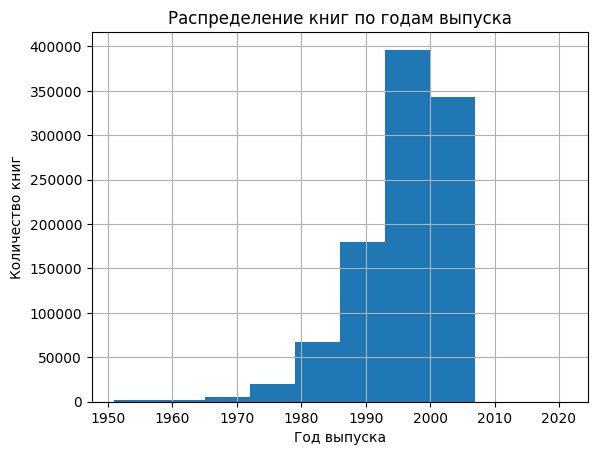

In [25]:
books_merge_copy_4 = books_merge_copy_3.copy()
books_merge_copy_4["year"] = books_merge_copy_4["Year-Of-Publication"].apply(lambda x: x if str(x).isdigit() and int(x) > 1950 and int(x) <= 2023 else np.nan)
books_merge_copy_4 = books_merge_copy_4.dropna(subset=["year"])
books_merge_copy_4['year'] = books_merge_copy_4['year'].astype(int)

hist_years_2 = books_merge_copy_4.query("year>1940")['year'].hist()

plt.xlabel('Год выпуска')
plt.ylabel('Количество книг')
plt.title('Распределение книг по годам выпуска')

plt.show()

3. Покажем на [столбчатой диаграмме](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.barh.html) топ-5 стран, в которых живут пользователи из датасета. Для этого понадобится сгруппировать столбец со страной методом [groupby()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html). Не забудьте отсортировать столбцы ([sort_values()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sort_values.html)).

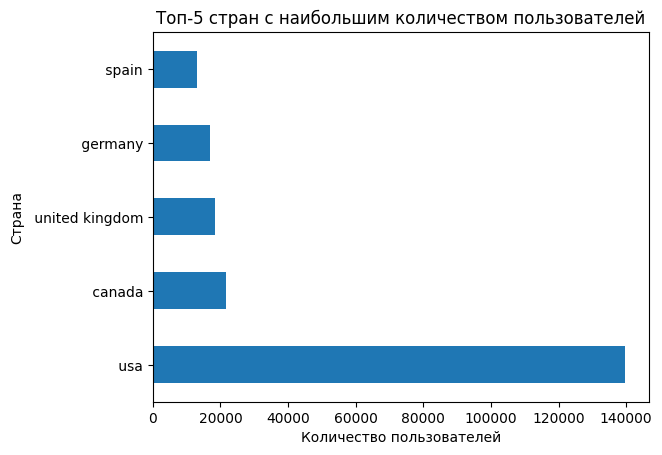

In [26]:
users_copy = users.copy()
users_copy['Location'] = users_copy['Location'].apply(lambda x:x.split(',')[-1])
users_copy['Location'].value_counts().head(5).plot(kind='barh')
plt.ylabel('Страна')
plt.xlabel('Количество пользователей')
plt.title('Топ-5 стран с наибольшим количеством пользователей')
plt.show()

### Упражнения

Теперь выполним несколько упражнений с данными.

1. Найдите книги, которые оценивали и жители России, и жители США. Посчитайте, жители какой страны в среднем ставили более высокие оценки одним и тем же книгам. Ретинг 0 не учитывайте.

In [27]:
filtered_data = books_merge_copy_3[books_merge_copy_3['Book-Rating'] != 0]

ratings_russia = filtered_data[filtered_data['country'].str.contains('russia', case=False, na=False)]
ratings_usa = filtered_data[filtered_data['country'].str.contains('usa', case=False, na=False)]

average_rating_russia = ratings_russia.groupby('Book-Title')['Book-Rating'].mean().reset_index()
average_rating_usa = ratings_usa.groupby('Book-Title')['Book-Rating'].mean().reset_index()

merged_ratings = pd.merge(average_rating_russia, average_rating_usa, on='Book-Title', suffixes=('_Russia', '_USA'))

higher_rating_russia = merged_ratings[merged_ratings['Book-Rating_Russia'] > merged_ratings['Book-Rating_USA']]
higher_rating_usa = merged_ratings[merged_ratings['Book-Rating_Russia'] < merged_ratings['Book-Rating_USA']]

print("Количество книг с высшим средним рейтингом в России:", len(higher_rating_russia))
print("Количество книг с высшим средним рейтингом в США:", len(higher_rating_usa))

Количество книг с высшим средним рейтингом в России: 4
Количество книг с высшим средним рейтингом в США: 0


2. Найдите год, в который было выпущено наибольшее количество книг. И год, в который наименьшее. Выведите годы и количество выпущенных книг.

In [28]:
yearly_book_counts = books_merge_copy['year'].value_counts().reset_index()
yearly_book_counts.columns = ['Year', 'Book Count']

max_books_year = yearly_book_counts[yearly_book_counts['Book Count'] == yearly_book_counts['Book Count'].max()]

min_books_year = yearly_book_counts[yearly_book_counts['Book Count'] == yearly_book_counts['Book Count'].min()]

print("Год(ы) с наибольшим количеством выпущенных книг:")
for year, count in zip(max_books_year['Year'], max_books_year['Book Count']):
    print(f"Год: {year}, Количество выпущенных книг: {count}")

print("\nГод(ы) с наименьшим количеством выпущенных книг:")
for year, count in zip(min_books_year['Year'], min_books_year['Book Count']):
    print(f"Год: {year}, Количество выпущенных книг: {count}")

Год(ы) с наибольшим количеством выпущенных книг:
Год: 2002, Количество выпущенных книг: 91800

Год(ы) с наименьшим количеством выпущенных книг:
Год: 2008, Количество выпущенных книг: 1
Год: 1897, Количество выпущенных книг: 1
Год: 1376, Количество выпущенных книг: 1
Год: 1904, Количество выпущенных книг: 1
Год: 1914, Количество выпущенных книг: 1
Год: 1917, Количество выпущенных книг: 1
Год: 1378, Количество выпущенных книг: 1
Год: 2012, Количество выпущенных книг: 1
Год: 1910, Количество выпущенных книг: 1
Год: 1934, Количество выпущенных книг: 1
Год: 1806, Количество выпущенных книг: 1
Год: 1906, Количество выпущенных книг: 1
Год: 1919, Количество выпущенных книг: 1


## Упражнения с данными в pyspark

Повторим все те же действия, но с помощью PySpark.

### Подготовка

Загрузим данные и посмотрим на них. Метод show() зпускает выполнение операций, прописанных для датафрейма.

In [29]:
books = spark.read.option("header", True).csv("Books.csv")
ratings = spark.read.option("header", True).csv("Ratings.csv")
users = spark.read.option("header", True).csv("Users.csv")
books.show()
ratings.show()
users.show()

+----------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+
|      ISBN|          Book-Title|         Book-Author|Year-Of-Publication|           Publisher|         Image-URL-S|         Image-URL-M|         Image-URL-L|
+----------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+
|0195153448| Classical Mythology|  Mark P. O. Morford|               2002|Oxford University...|http://images.ama...|http://images.ama...|http://images.ama...|
|0002005018|        Clara Callan|Richard Bruce Wright|               2001|HarperFlamingo Ca...|http://images.ama...|http://images.ama...|http://images.ama...|
|0060973129|Decision in Normandy|        Carlo D'Este|               1991|     HarperPerennial|http://images.ama...|http://images.ama...|http://images.ama...|
|0374157065|Flu: The Story of...|    Gina Bari

Посмотрим на размеры датафреймов.

In [30]:
(books.count(), len(books.columns)), (ratings.count(), len(ratings.columns)), (users.count(), len(users.columns))

((271360, 8), (1149780, 3), (278859, 3))

Воспользуйтесь [функцией](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.join.html) join, чтобы объединить три датафрейма в один.

In [31]:
books_join = books.join(ratings, "ISBN", "inner")
books_join = books_join.join(users, "User-ID", "inner")

In [32]:
books_join.show()

+-------+----------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+-----------+--------------------+----+
|User-ID|      ISBN|          Book-Title|         Book-Author|Year-Of-Publication|           Publisher|         Image-URL-S|         Image-URL-M|         Image-URL-L|Book-Rating|            Location| Age|
+-------+----------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+-----------+--------------------+----+
|   1000|8850200005|Il Dio Delle Picc...|       Arundhati Roy|               2002|     Distribooks Inc|http://images.ama...|http://images.ama...|http://images.ama...|          0|teramo, abruzzo, ...|34.0|
| 100004|0345339703|The Fellowship of...|      J.R.R. TOLKIEN|               1986|             Del Rey|http://images.ama...|http://images.ama...|http://images.ama...|         10|sa

In [33]:
(books_join.count(), len(books_join.columns))

(1031136, 12)

В столбце Location указано достаточно много данных: город, регион, страна. Давайте разделим этот столбец на три с помощью функции [split()](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.split.html) и функции [withColumn()](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.withColumn.html). Если в процессе у вас образовались лишние столбцы, удалите их методом [drop()](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.drop.html). Это случилось потому, что со столбцом с локацией есть некоторые проблемы, но мы на них сейчас не будем обращать внимание.

In [34]:
from pyspark.sql.functions import split
books_join = books_join.withColumn("City", split(books_join["Location"], ",")[0])
books_join = books_join.withColumn("Region", split(books_join["Location"], ",")[1])
books_join = books_join.withColumn("Country", split(books_join["Location"], ",")[2])

books_join = books_join.drop("Location")
books_join.show()

+-------+----------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+-----------+----+----------+-----------------+-------+
|User-ID|      ISBN|          Book-Title|         Book-Author|Year-Of-Publication|           Publisher|         Image-URL-S|         Image-URL-M|         Image-URL-L|Book-Rating| Age|      City|           Region|Country|
+-------+----------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+-----------+----+----------+-----------------+-------+
|   1000|8850200005|Il Dio Delle Picc...|       Arundhati Roy|               2002|     Distribooks Inc|http://images.ama...|http://images.ama...|http://images.ama...|          0|34.0|    teramo|          abruzzo|  italy|
| 100004|0345339703|The Fellowship of...|      J.R.R. TOLKIEN|               1986|             Del Rey|http://images

Узнаем немного больше о книгах и пользователях.
1. Построим [гистограмму](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.hist.html) распределения возрастов пользователей. Видно, что там есть отсутствующие значения. Будем их пока игнорировать.

In [35]:
books_join.describe(["Age"]).show()

+-------+------------------+
|summary|               Age|
+-------+------------------+
|  count|            753333|
|   mean| 37.39758831409003|
| stddev|14.098294242258431|
|    min|      \""n/a\"""""|
|    max|              99.0|
+-------+------------------+



Для того, чтобы отсеять лишние строки, можно воспользоваться методом [filter()/where()](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.filter.html).

Для сортировки можно воспользоваться методом [sort()](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.sort.html).

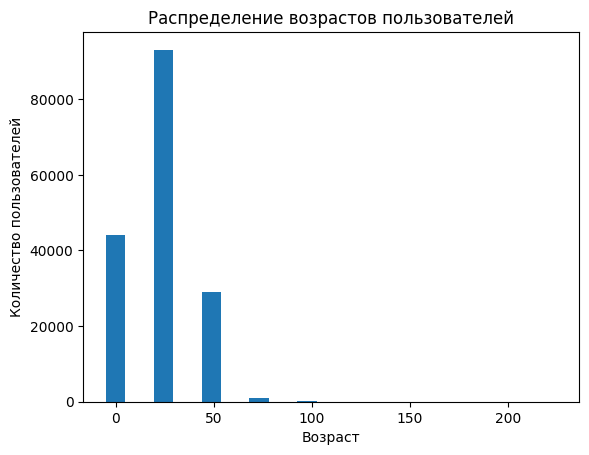

In [36]:
filtered_df = users.filter(users['Age'].isNotNull())
filtered_df = filtered_df.withColumn("Age", filtered_df["Age"].cast("integer"))
hist_data = filtered_df.select("Age").rdd.flatMap(lambda x: x).histogram(10)
age_values = hist_data[0]
age_counts = hist_data[1]
plt.bar(age_values[:-1], age_counts, width=10)
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')
plt.title('Распределение возрастов пользователей')
plt.show()

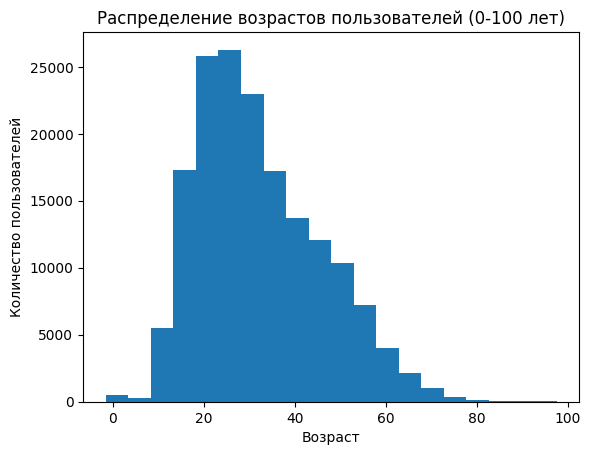

In [37]:
filtered_df_2 = users.filter(users['Age'].isNotNull())
filtered_df_2 = filtered_df_2.withColumn("Age", filtered_df_2["Age"].cast("integer"))
filtered_df_2 = filtered_df_2.filter((filtered_df_2['Age'] > 0) & (filtered_df_2['Age'] <= 100))
hist_data = filtered_df_2.select("Age").rdd.flatMap(lambda x: x).histogram(20)
age_values = hist_data[0]
age_counts = hist_data[1]
plt.bar(age_values[:-1], age_counts, width=5)
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')
plt.title('Распределение возрастов пользователей (0-100 лет)')
plt.show()

Какой можно сделать вывод о возрасте пользователей?

In [38]:
filtered_df_2.describe(["Age"]).show()

+-------+------------------+
|summary|               Age|
+-------+------------------+
|  count|            166893|
|   mean|34.654263510153214|
| stddev|13.727236106142072|
|    min|                 1|
|    max|               100|
+-------+------------------+



2. Выясним, книги каких эпох представлены в датасете. Для этого построим еще диаграмму, теперь - с распределением кол-ва книг по годам.

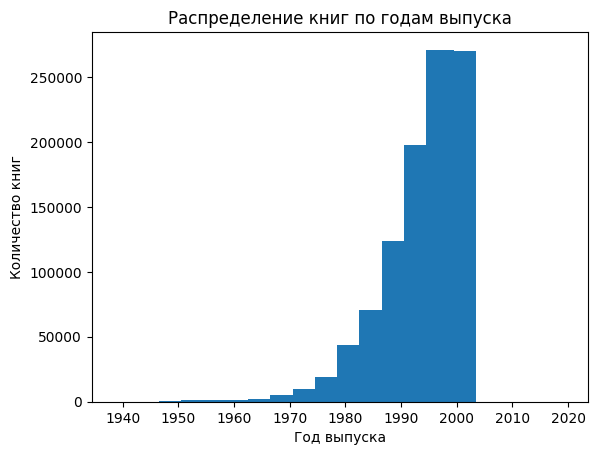

In [43]:
from pyspark.sql.functions import col

filtered_df_3 = books_join.filter((col('Year-Of-Publication').isNotNull()) & (col('Year-Of-Publication').cast("int") > 0) &(col('Year-Of-Publication').cast("int") <= 2023))

filtered_df_3 = filtered_df_3.withColumn("year", filtered_df_3["Year-Of-Publication"].cast("int"))
filtered_df_3 = filtered_df_3.filter(filtered_df_3['year'] > 1940)

hist_data = filtered_df_3.select("year").rdd.flatMap(lambda x: x).histogram(20)

year_values = hist_data[0]
year_counts = hist_data[1]

plt.bar(year_values[:-1], year_counts, width=5)
plt.xlabel('Год выпуска')
plt.ylabel('Количество книг')
plt.title('Распределение книг по годам выпуска')
plt.show()

Вероятно, у вас возникла ошибка о невозможности сравнения строк и целых чисел. Посмотрим на уникальные значения с помощью метода [distinct()](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.distinct.html).

In [41]:
distinct_years = books_join.select("Year-Of-Publication").distinct()

distinct_years.show()

+--------------------+
| Year-Of-Publication|
+--------------------+
|                1953|
|                1957|
|                1897|
|                1987|
|                1956|
|                1936|
|                2020|
|                1958|
|                1943|
|                1972|
|                1931|
| and tasty! : com...|
| and Musicians at...|
| and Box-Office M...|
|                1988|
|                1911|
|                1926|
|                1938|
|\"" \""Drachenste...|
|                1932|
+--------------------+
only showing top 20 rows



В 4 строках некорректно открепили автора от названия. Для упрощения работы исключим эти строки из датасета.

In [44]:
invalid_values = ['DK Publishing Inc', 'Gallimard']
filtered_df_4 = books_join.filter(~books_join['Book-Author'].isin(invalid_values))
filtered_df_4

DataFrame[User-ID: string, ISBN: string, Book-Title: string, Book-Author: string, Year-Of-Publication: string, Publisher: string, Image-URL-S: string, Image-URL-M: string, Image-URL-L: string, Book-Rating: string, Age: string, City: string, Region: string, Country: string]

Теперь продолжим с построением графика. Но сначала преобразуем весь столбец в целые числа с помощью метода [cast()](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.Column.cast.html).

In [45]:
book_join_2 = filtered_df_4.withColumn("Year-Of-Publication", filtered_df_4["Year-Of-Publication"].cast("int"))

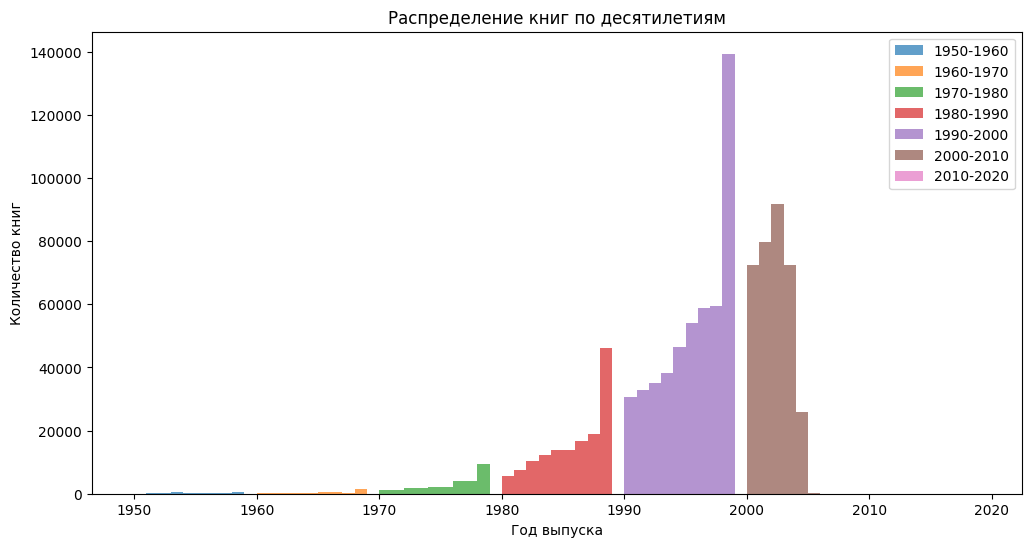

In [46]:
import matplotlib.pyplot as plt

filtered_df_5 = filtered_df_4.filter((filtered_df_4['Year-Of-Publication'] >= 1950) & (filtered_df_4['Year-Of-Publication'] <= 2023))
year_data = filtered_df_5.select("Year-Of-Publication").toPandas()
year_data["Year-Of-Publication"] = year_data["Year-Of-Publication"].astype(int)

bins = [1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020]

plt.figure(figsize=(12, 6))

for i in range(len(bins) - 1):
    start_year = bins[i]
    end_year = bins[i + 1]
    data_subset = year_data[(year_data["Year-Of-Publication"] >= start_year) & (year_data["Year-Of-Publication"] < end_year)]["Year-Of-Publication"]

    plt.hist(data_subset, bins=range(start_year, end_year, 1), alpha=0.7, label=f"{start_year}-{end_year}")

plt.xlabel('Год выпуска')
plt.ylabel('Количество книг')
plt.title('Распределение книг по десятилетиям')
plt.legend()
plt.show()



3. Покажем на столбчатой диаграмме топ-5 стран, в которых живут пользователи из датасета. Для этого понадобится сгруппировать столбец со страной методом [groupBy()](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.groupBy.html). Не забудьте отсортировать столбцы.

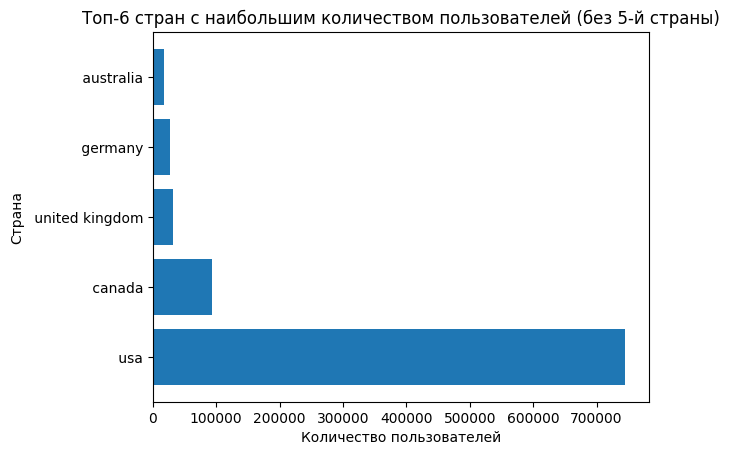

In [60]:
from pyspark.sql.functions import col, count, desc

country_counts = book_join_2.groupBy("Country").agg(count("User-ID").alias("UserCount"))
top_countries = country_counts.orderBy(desc("UserCount")).limit(6)
top_countries_pd = top_countries.toPandas()

top_countries_pd = top_countries_pd.drop(4)

plt.barh(top_countries_pd["Country"], top_countries_pd["UserCount"])
plt.xlabel('Количество пользователей')
plt.ylabel('Страна')
plt.title('Топ-6 стран с наибольшим количеством пользователей (без 5-й страны)')
plt.show()

### Упражнения

Теперь выполним несколько упражнений с данными.

1. Найдите книги, которые оценивали и жители России, и жители США. Посчитайте, жители какой страны в среднем ставили более высокие оценки одним и тем же книгам. Ретинг 0 не учитывайте.

In [64]:
from pyspark.sql.types import DoubleType

ratings_russia = filtered_df_5.filter(filtered_df_5["country"].rlike("russia"))
ratings_usa = filtered_df_5.filter(filtered_df_5["country"].rlike("usa"))

ratings_russia = ratings_russia.withColumn("Book-Rating", ratings_russia["Book-Rating"].cast(DoubleType()))
ratings_usa = ratings_usa.withColumn("Book-Rating", ratings_usa["Book-Rating"].cast(DoubleType()))

ratings_russia = ratings_russia.filter(ratings_russia["Book-Rating"] != 0)
ratings_usa =  ratings_usa.filter(ratings_usa["Book-Rating"] != 0)

average_rating_russia = ratings_russia.groupBy("Book-Title").mean("Book-Rating").withColumnRenamed("avg(Book-Rating)", "AvgRating_Russia")
average_rating_usa = ratings_usa.groupBy("Book-Title").mean("Book-Rating").withColumnRenamed("avg(Book-Rating)", "AvgRating_USA")

merged_ratings = average_rating_russia.join(average_rating_usa, "Book-Title", "inner")

higher_rating_russia = merged_ratings.filter(col("AvgRating_Russia") > col("AvgRating_USA"))

higher_rating_usa = merged_ratings.filter(col("AvgRating_Russia") < col("AvgRating_USA"))

count_russia = higher_rating_russia.count()
count_usa = higher_rating_usa.count()

print("Количество книг с высшим средним рейтингом в России:", count_russia)
print("Количество книг с высшим средним рейтингом в США:", count_usa)

Количество книг с высшим средним рейтингом в России: 4
Количество книг с высшим средним рейтингом в США: 0


2. Найдите год, в который было выпущено наибольшее количество книг. И год, в который наименьшее. Выведите годы и количество выпущенных книг.

In [66]:
filtered_df_6 = filtered_df_4.filter((filtered_df_4['Year-Of-Publication'] <= 2023))

yearly_book_counts = filtered_df_6.groupBy("Year-Of-Publication").count().withColumnRenamed("count", "BookCount")

max_books_count = yearly_book_counts.agg({"BookCount": "max"}).collect()[0][0]
max_books_years = yearly_book_counts.filter(col("BookCount") == max_books_count)

min_books_count = yearly_book_counts.agg({"BookCount": "min"}).collect()[0][0]
min_books_years = yearly_book_counts.filter(col("BookCount") == min_books_count)

max_books_years = max_books_years.collect()
min_books_years = min_books_years.collect()

print("Год(ы) с наибольшим количеством выпущенных книг:")
for row in max_books_years:
    year = row["Year-Of-Publication"]
    count = row["BookCount"]
    print(f"Год: {year}, Количество выпущенных книг: {count}")

print("\nГод(ы) с наименьшим количеством выпущенных книг:")
for row in min_books_years:
    year = row["Year-Of-Publication"]
    count = row["BookCount"]
    print(f"Год: {year}, Количество выпущенных книг: {count}")

Год(ы) с наибольшим количеством выпущенных книг:
Год: 2002, Количество выпущенных книг: 91792

Год(ы) с наименьшим количеством выпущенных книг:
Год: 1897, Количество выпущенных книг: 1
Год:  1961, Количество выпущенных книг: 1
Год: 1934, Количество выпущенных книг: 1
Год: 1376, Количество выпущенных книг: 1
Год: 2012, Количество выпущенных книг: 1
Год: 1910, Количество выпущенных книг: 1
Год: 1919, Количество выпущенных книг: 1
Год: 1906, Количество выпущенных книг: 1
Год: 1904, Количество выпущенных книг: 1
Год: 1378, Количество выпущенных книг: 1
Год: 2008, Количество выпущенных книг: 1
Год: 1917, Количество выпущенных книг: 1
Год: 1914, Количество выпущенных книг: 1
Год: 1806, Количество выпущенных книг: 1
